# Stocker for Prediction

Stocker is a Python tool for stock exploration. Once we have the required libraries installed we can start a Jupyter Notebook in the same folder as the script and import the Stocker class

Python 3.6 and the following packages are required:

1. quandl 3.3.0
2. matplotlib 2.1.1
3. numpy 1.14.0
4. fbprophet 0.2.1
5. pystan 2.17.0.0
6. pandas 0.22.0
7. pytrends 4.3.0

In [1]:
from stocker import Stocker

### The class is now accessible in our session. We construct an object of the Stocker class by passing it any valid stock ticker (bold is output). Here we are taking Apple Stocks

In [3]:
apple = Stocker('AAPL')

AAPL Stocker Initialized. Data covers 1980-12-12 to 2018-03-27.


### Just like that we have 20 years of daily Apple stock data to explore! Stocker is built on the Quandl financial library and with over 3000 stocks to use. We can make a simple plot of the stock history using the plot_stock method:

Maximum Adj. Close = 181.72 on 2018-03-12.
Minimum Adj. Close = 0.16 on 1982-07-08.
Current Adj. Close = 168.34 on 2018-03-27.



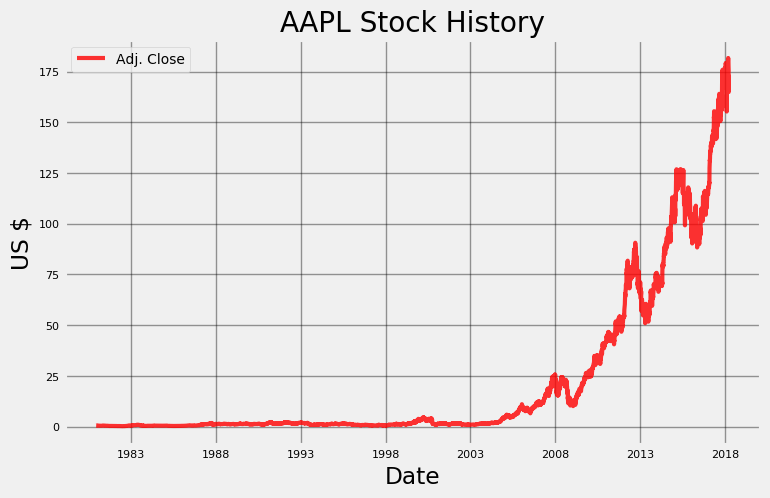

In [4]:
apple.plot_stock()

#### The analysis capabilities of Stocker can be used to find the overall trends and patterns within the data, but we will focus on predicting the future price. Predictions in Stocker are made using an additive model which considers a time series as a combination of an overall trend along with seasonalities on different time scales such as daily, weekly, and monthly. Stocker uses the prophet package developed by Facebook for additive modeling. Creating a model and making a prediction can be done with Stocker in a single line:

C:\Users\lalwa\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


Predicted Price on 2018-06-25 = $182.93


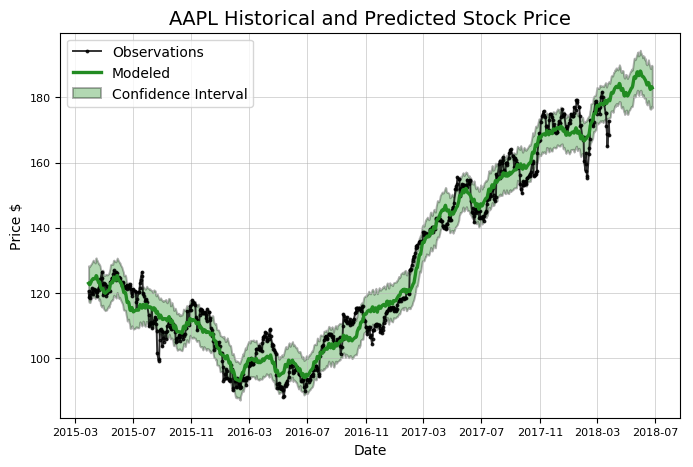

In [5]:
# predict days into the future
model, model_data = apple.create_prophet_model(days=90)

Notice that the prediction, the green line, contains a confidence interval. This represents the model’s uncertainty in the forecast. In this case, the confidence interval width is set at 80%, meaning we expect that this range will contain the actual value 80% of the time. The confidence interval grows wide further out in time because the estimate has more uncertainty as it gets further away from the data. Any time we make a prediction we must include a confidence interval. Although most people tend to want a simple answer about the future, our forecast must reflect that we live in an uncertain world!

Anyone can make stock predictions: simply pick a number and that’s your estimate. For us to trust our model we need to evaluate it for accuracy.There are a number of methods in Stocker for assessing model accuracy.

## Evaluate Predictions

To calculate accuracy, we need a test set and a training set. We need to know the answers — the actual stock price — for the test set, so we will use the past one year of historical data (2017 in our case). When training, we do not let our model see the answers to the test set, so we use three years of data previous to the testing time frame (2014–2016). The basic idea of supervised learning is the model learns the patterns and relationships in the data from the training set and then is able to correctly reproduce them for the test data.

We need to quantify our accuracy, so we using the predictions for the test set and the actual values, we calculate metrics including average dollar error on the testing and training set, the percentage of the time we correctly predicted the direction of a price change, and the percentage of the time the actual price fell within the predicted 80% confidence interval. All of these calculations are automatically done by Stocker with a nice visual:

C:\Users\lalwa\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\lalwa\OneDrive\BDIA_Final_Project\stocker.py:522: RuntimeWarning: invalid value encountered in sign
  test['correct'] = (np.sign(test['pred_diff']) == np.sign(test['real_diff'])) * 1



Prediction Range: 2017-03-27 to 2018-03-27.

Predicted price on 2018-03-24 = $207.57.
Actual price on    2018-03-23 = $164.94.

Average Absolute Error on Training Data = $2.84.
Average Absolute Error on Testing  Data = $11.96.

When the model predicted an increase, the price increased 48.59% of the time.
When the model predicted a  decrease, the price decreased  43.66% of the time.

The actual value was within the 80% confidence interval 57.43% of the time.


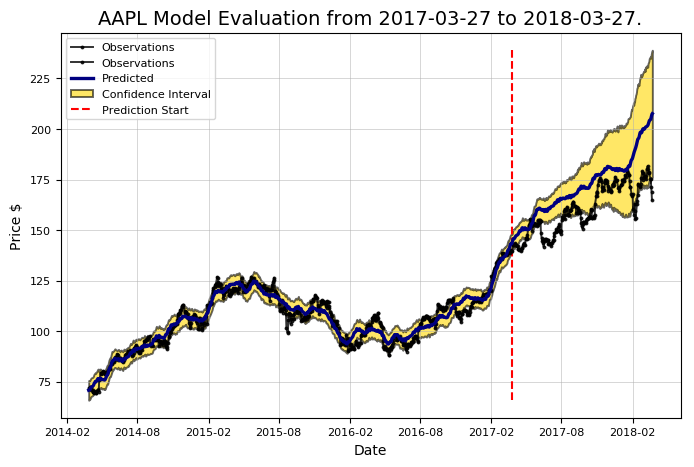

In [6]:
apple.evaluate_prediction()

##### Those are abysmal stats! We might as well have flipped a coin. If we were using this to invest, we would probably be better off buying something sensible like lottery tickets. However, don’t give up on the model just yet. We usually expect a first model to be rather bad because we are using the default settings (called hyperparameters). If our initial attempts are not successful, we can turn these knobs to make a better model. There are a number of different settings to adjust in a Prophet model, with the most important the changepoint prior scale which controls the amount of weight the model places on shifts in the trend of the data.

C:\Users\lalwa\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


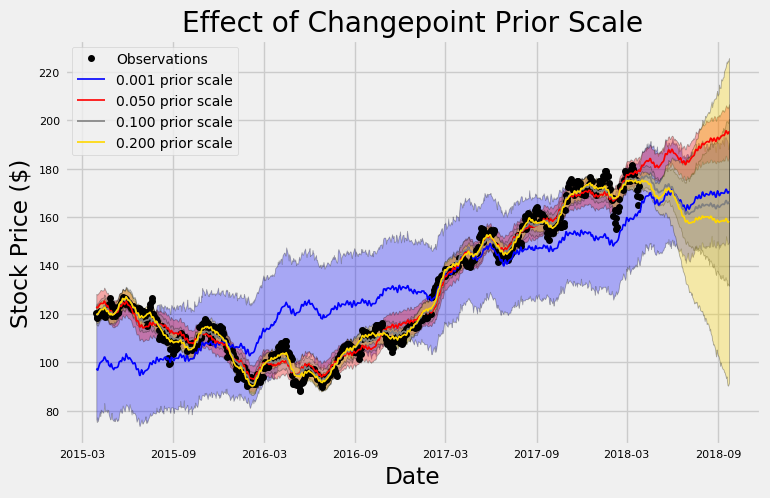

In [7]:
# changepoint priors is the list of changepoints to evaluate
apple.changepoint_prior_analysis(changepoint_priors=[0.001, 0.05, 0.1, 0.2])

### Changepoint Prior Selection

Changepoints represent where a time series goes from increasing to decreasing or from increasing slowly to increasingly rapidly (or vice versa). They occur at the places with the greatest change in the rate of the time series. The changepoint prior scale represents the amount of emphasis given to the changepoints in the model. This is used to control overfitting vs. underfitting (also known as the bias vs. variance tradeoff).

A higher prior creates a model with more weight on the changepoints and a more flexible fit. This may lead to overfitting because the model will closely stick to the training data and not be able to generalize to new test data. Lowering the prior decreases the model flexibility which can cause the opposite problem: underfitting. This occurs when our model does not follow the training data closely enough and fails to learn the underlying patterns. Figuring out the proper settings to achieve the right balance is more a matter of engineering than of theory, and here we must rely on empirical results. The Stocker class contains two different ways to choose an appropriate prior: visually and quantitatively. We can start off with the graphical method:

Here, we are training on three years of data and then showing predictions for six months. We do not quantify the predictions here because we are just trying to understand the role of the changepoint prior. This graph does a great job of illustrating under- vs overfitting! The lowest prior, the blue line, does not follow the training data, the black observations , very closely. It kind of does its own thing and picks a route through the general vicinity of the data. In contrast, the highest prior, the yellow line, sticks to the training observations as closely as possible. The default value for the changepoint prior is 0.05 which falls somewhere in between the two extremes.

Notice also the difference in uncertainty (shaded intervals) for the priors. The lowest prior has the largest uncertainty on the training data, but the smallest uncertainty on the test data. In contrast, the highest prior has the smallest uncertainty on the training data but the greatest uncertainty on the test data. The higher the prior, the more confident it is on the training data because it closely follows each observation. When it comes to the test data however, an overfit model is lost without any data points to anchor it. As stocks have quite a bit of variability, we probably want a more flexible model than the default so the model can capture as many patterns as possible.

Now that we have an idea of the effect of the prior, we can numerically evaluate different values using a training and validation set:

Here, we have to be careful that our validation data is not the same as our testing data. If this was the case, we would create the best model for the test data, but then we would just be overfitting the test data and our model could not translate to real world data. In total, as is commonly done in data science, we are using three different sets of data: a training set (2013–2015), a validation set (2016), and a testing set (2017).

We evaluated four priors with four metrics: training error, training range (confidence interval), testing error, and testing range (confidence interval) with all values in dollars. As we saw in the graph, the higher the prior, the lower the training error and the lower the uncertainty on the training data. We also see that a higher prior decreases our testing error, backing up our intuition that closely fitting to the data is a good idea with stocks. In exchange for greater accuracy on the test set, we get a greater range of uncertainty on the test data with the increased prior.

#### The Stocker prior validation also displays two plots illustrating these points:


Validation Range 2016-04-04 to 2017-04-03.



C:\Users\lalwa\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


     cps  train_err  train_range   test_err  test_range
0  0.001   9.176345    29.121191  22.056629   29.089919
1  0.050   2.305214     7.563483  23.879230   25.237245
2  0.100   1.838516     6.028616  15.170169   68.000370
3  0.200   1.590002     5.240994  23.268461  121.790984


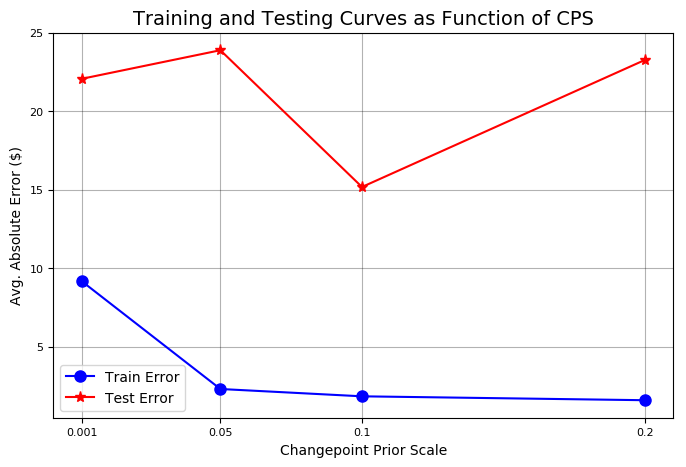

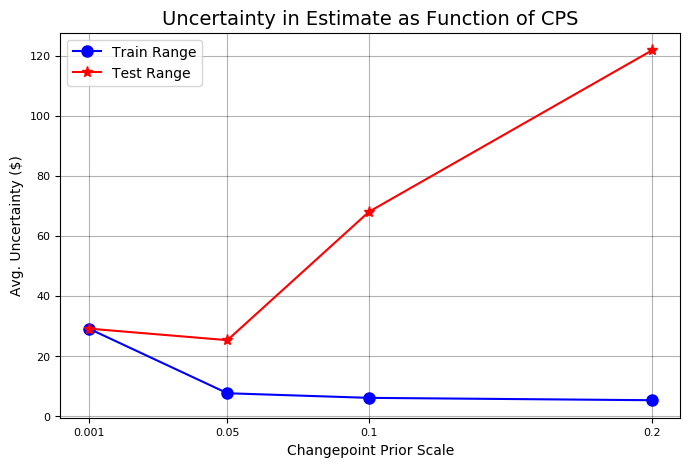

In [8]:
apple.changepoint_prior_validation(start_date='2016-04-04', end_date='2017-04-03', changepoint_priors=[0.001, 0.05, 0.1, 0.2])

###### Since the 0.1 prior produced the lowest testing error, we should try to decrease the prior even lower to see if we get better performance. We can refine our search by passing in additional values to the validation method:


Validation Range 2017-01-04 to 2018-01-03.



C:\Users\lalwa\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


    cps  train_err  train_range   test_err  test_range
0  0.06   2.905276     9.120275  16.187066   29.318954
1  0.08   2.639694     8.399911  14.447338   42.603310
2  0.10   2.509656     8.053559  14.201456   53.891797


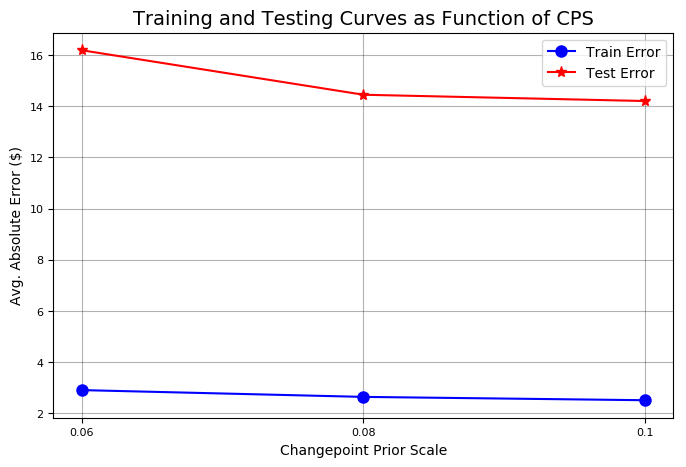

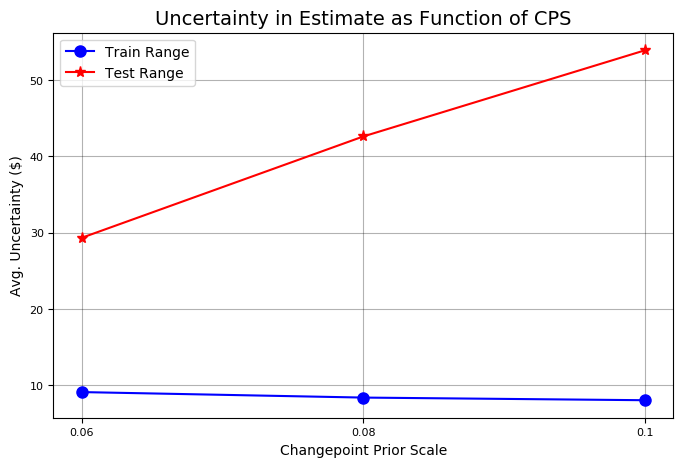

In [14]:
# test more changepoint priors on same validation range
apple.changepoint_prior_validation(start_date='2017-01-04', end_date='2018-01-03', 
                                    changepoint_priors=[0.06, 0.08, 0.1])

#### The test set error is minimized at a prior of 0.08. We will set the changepoint prior attribute of the Stocker object appropriately.

In [15]:
apple.changepoint_prior_scale = 0.08

# Evaluating Refined Model
Now that our model is optimized, we can again evaluate it:

C:\Users\lalwa\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\lalwa\OneDrive\BDIA_Final_Project\stocker.py:522: RuntimeWarning: invalid value encountered in sign
  test['correct'] = (np.sign(test['pred_diff']) == np.sign(test['real_diff'])) * 1



Prediction Range: 2017-03-27 to 2018-03-27.

Predicted price on 2018-03-24 = $203.27.
Actual price on    2018-03-23 = $164.94.

Average Absolute Error on Training Data = $2.57.
Average Absolute Error on Testing  Data = $9.22.

When the model predicted an increase, the price increased 47.02% of the time.
When the model predicted a  decrease, the price decreased  41.25% of the time.

The actual value was within the 80% confidence interval 75.10% of the time.


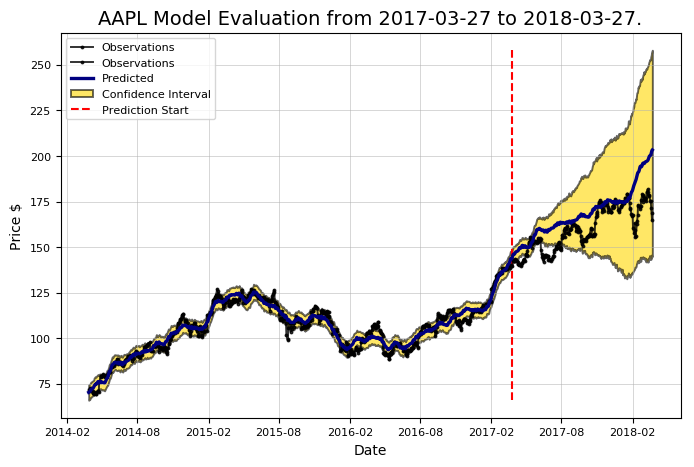

In [16]:
apple.evaluate_prediction()

###### That looks better! This shows the importance of model optimization. Using default values provides a reasonable first guess, but we need to be sure we are using the correct model “settings,” just like we try to optimize how a stereo sounds by adjusting balance and fade 

### Playing the Stock Market

Making predictions is an interesting exercise, but the real fun is looking at how well these forecasts would play out in the actual market. Using the evaluate_prediction method, we can “play” the stock market using our model over the evaluation period. We will use a strategy informed by our model which we can then compare to the simple strategy of buying and holding the stock over the entire period.

###### The rules of our strategy are straightforward:

1. On each day the model predicts the stock to increase, we purchase the stock at the beginning of the day and sell at the end of the day. When the model predicts a decrease in price, we do not buy any stock.
2. If we buy stock and the price increases over the day, we make the increase times the number of shares we bought.
3. If we buy stock and the price decreases, we lose the decrease times the number of shares.

We play this each day for the entire evaluation period which in our case is 2017. To play, add the number of shares to the method call. Stocker will inform us how the strategy played out in numbers and graphs:

C:\Users\lalwa\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\lalwa\OneDrive\BDIA_Final_Project\stocker.py:522: RuntimeWarning: invalid value encountered in sign
  test['correct'] = (np.sign(test['pred_diff']) == np.sign(test['real_diff'])) * 1
C:\Users\lalwa\OneDrive\BDIA_Final_Project\stocker.py:613: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  test_pred_increase['pred_profit'] = prediction_profit


You played the stock market in AAPL from 2017-03-27 to 2018-03-27 with 1000 shares.

When the model predicted an increase, the price increased 47.02% of the time.
When the model predicted a  decrease, the price decreased  41.25% of the time.

The total profit using the Prophet model = $-86.31.
The Buy and Hold strategy profit =         $25201.15.

Thanks for playing the stock market!



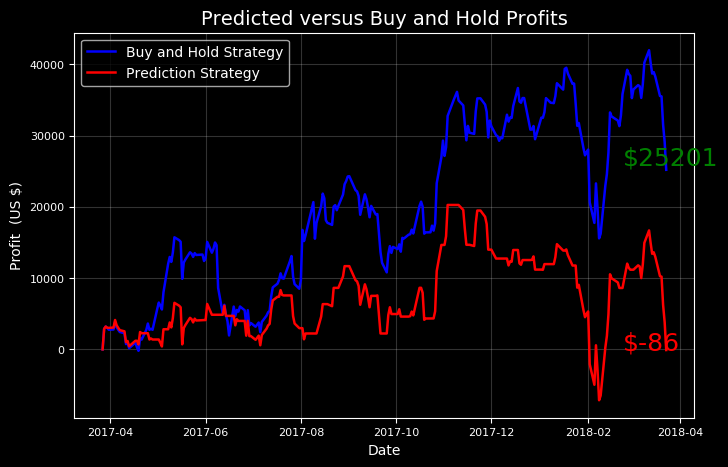

In [17]:
# Going big 
apple.evaluate_prediction(nshares=1000)

###### This shows us a valuable lesson: buy and hold! While we would have made a considerable sum playing our strategy, the better bet would simply have been to invest for the long term.

###### We can try other test periods to see if there are times when our model strategy beats the buy and hold method. Our strategy is rather conservative because we do not play when we predict a market decrease, so we might expect to do better than a holding strategy when the stock takes a downturn.

## Future Predictions
Now that we are satisfied we have a decent model, we can make future predictions using the predict_future() method.

C:\Users\lalwa\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):



Predicted Increase: 

         Date    estimate    change       upper       lower
2  2018-03-29  176.763847  0.490654  181.494937  172.447483
3  2018-03-30  177.609317  0.845470  182.221116  172.883040
5  2018-04-01  178.500356  0.891039  183.201742  173.797113
8  2018-04-04  178.056504  0.011416  182.810938  173.389059
9  2018-04-05  178.352361  0.295857  183.154428  173.654205
10 2018-04-06  178.730551  0.378191  183.732521  173.818158

Predicted Decrease: 

        Date    estimate    change       upper       lower
1 2018-03-28  176.273194 -0.132293  180.755341  171.438279
6 2018-04-02  178.295104 -0.205252  183.279213  173.646671
7 2018-04-03  178.045088 -0.250016  182.702556  173.223571


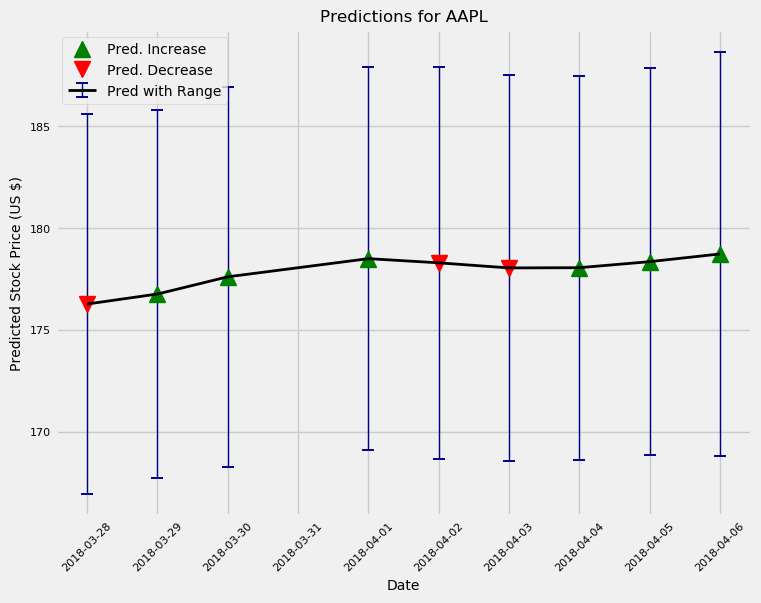


Predicted Increase: 

          Date    estimate    change       upper       lower
2   2018-03-29  176.763847  0.490654  181.507961  172.021356
3   2018-03-30  177.609317  0.845470  182.185794  172.891603
5   2018-04-01  178.500356  0.891039  183.433200  173.781622
8   2018-04-04  178.056504  0.011416  182.511590  173.368459
9   2018-04-05  178.352361  0.295857  183.129039  173.834737
10  2018-04-06  178.730551  0.378191  183.763987  174.021377
12  2018-04-08  179.133615  0.403063  183.609886  174.427600
13  2018-04-09  179.223201  0.089586  184.058305  174.471867
14  2018-04-10  179.302338  0.079137  183.978106  174.855096
20  2018-04-16  179.181396  0.402941  183.900645  174.456356
21  2018-04-17  179.453048  0.271652  184.121472  174.509974
27  2018-04-23  177.181786  0.219008  182.344862  172.473575
34  2018-04-30  175.013484  0.404400  179.861761  170.108928
35  2018-05-01  175.082415  0.068931  179.985110  170.327044
40  2018-05-06  173.902331  0.196796  179.163869  168.304726
4

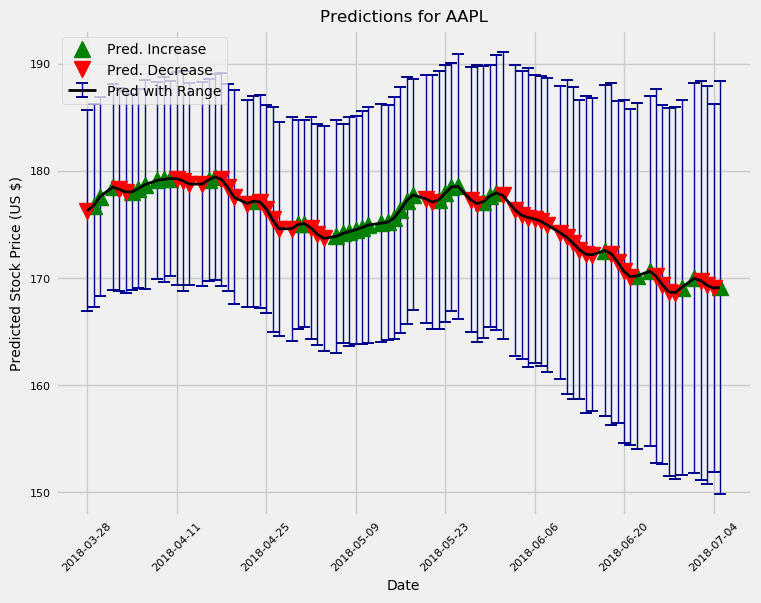

In [18]:
apple.predict_future(days=10)
apple.predict_future(days=100)

# Conclusion:

The uncertainty increases the further out in time we make estimates as expected. In reality, if we were using this model to actively trade, we would train a new model every day and would make predictions for a maximum of one day in the future.

While we might not get rich from the Stocker tool, the benefit is in the development rather than the end results! We can’t actually know if we can solve a problem until we try but it’s better to have tried and failed than to have never tried at all! 

# References :

https://github.com/WillKoehrsen/Data-Analysis/tree/master/stocker